In [89]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Import Data

In [51]:
# Load the dataset
df = pd.read_csv("Diabetes.csv")

# Display first 5 rows of the dataset
df.head()


,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [88]:
# Basic Info & Check for Duplicates/Missing
print(df.info())
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

# Optional: drop duplicates if any
df.drop_duplicates(inplace=True)
print("Shape after dropping duplicates:", df.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         1000 non-null   int64   
 1   No_Pation  1000 non-null   int64   
 2   Gender     1000 non-null   int64   
 3   AGE        1000 non-null   int64   
 4   Urea       1000 non-null   float64 
 5   Cr         1000 non-null   int64   
 6   HbA1c      1000 non-null   float64 
 7   Chol       1000 non-null   float64 
 8   TG         1000 non-null   float64 
 9   HDL        1000 non-null   float64 
 10  LDL        1000 non-null   float64 
 11  VLDL       1000 non-null   float64 
 12  BMI        1000 non-null   float64 
 13  CLASS      1000 non-null   object  
 14  Age_Group  1000 non-null   category
dtypes: category(1), float64(8), int64(5), object(1)
memory usage: 110.8+ KB
None

Missing values:
 ID           0
No_Pation    0
Gender       0
AGE          0
Urea         0
Cr           0
HbA1c  

## Cleaning Data

In [31]:
# Remove duplicate rows
df = df.drop_duplicates()


In [59]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())


In [60]:
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [61]:
df = df.dropna(how='all')


In [62]:
# Standardize Gender column
df['Gender'] = df['Gender'].str.upper().str.strip()

# Standardize CLASS column
df['CLASS'] = df['CLASS'].str.upper().str.strip()


In [63]:
# Remove invalid age values
df = df[df['AGE'] > 0]

# Remove invalid BMI values
df = df[df['BMI'] > 0]


In [64]:
# Check remaining missing values
df.isnull().sum()


ID           0
No_Pation    0
Gender       0
AGE          0
Urea         0
Cr           0
HbA1c        0
Chol         0
TG           0
HDL          0
LDL          0
VLDL         0
BMI          0
CLASS        0
dtype: int64

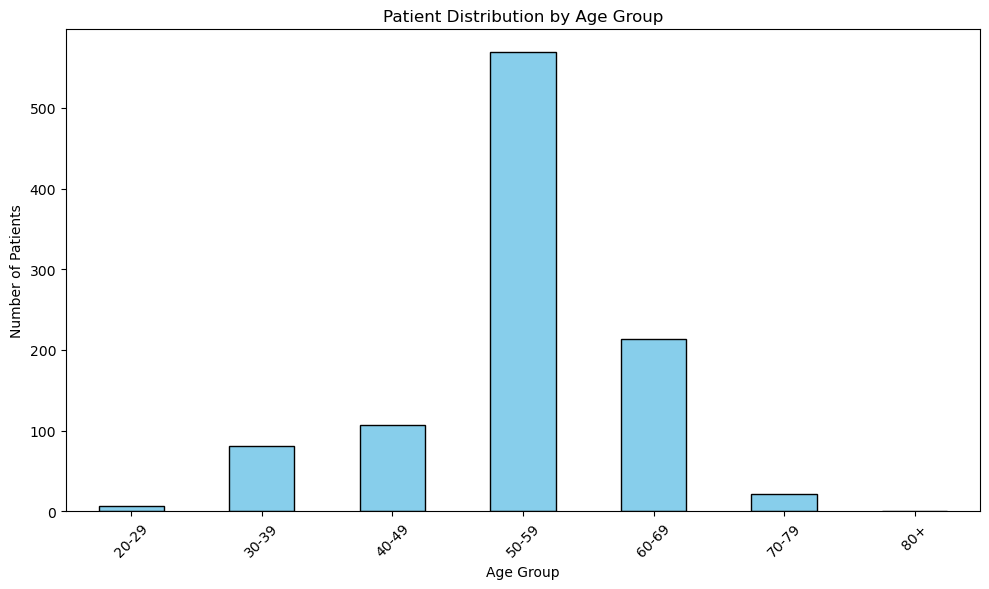

In [87]:
# Patient Distribution by Age Group (Bar Chart)
bins = [20, 30, 40, 50, 60, 70, 80, 100]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
df['Age_Group'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10,6))
age_counts = df['Age_Group'].value_counts().sort_index()
age_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Patient Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


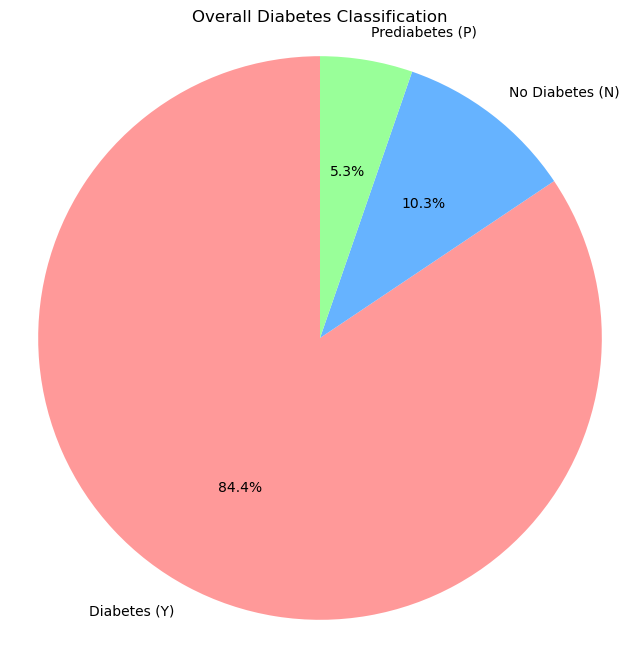

In [86]:
# Overall Diabetes Classification (Pie Chart)
plt.figure(figsize=(8,8))
class_counts = df['CLASS'].value_counts()
labels_pie = ['Diabetes (Y)', 'No Diabetes (N)', 'Prediabetes (P)']
plt.pie(class_counts, labels=labels_pie, autopct='%1.1f%%', startangle=90,
        colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Overall Diabetes Classification')
plt.axis('equal')
plt.show()

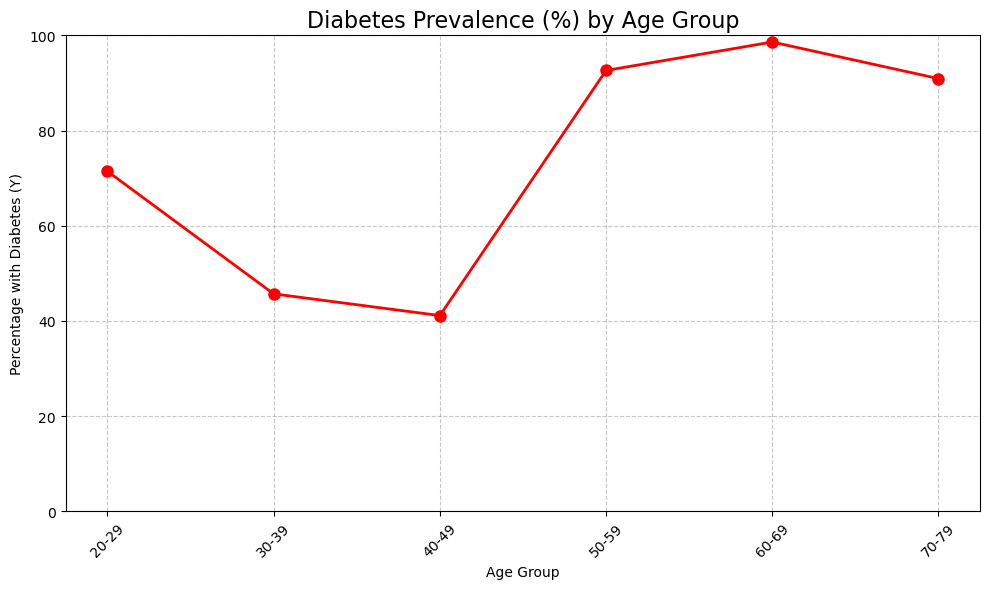

In [85]:
# Diabetes Prevalence (%) by Age Group (Line Chart)
diabetes_by_age = df.groupby('Age_Group', observed=True)['CLASS'].apply(
    lambda x: (x == 'Y').mean() * 100
)

plt.figure(figsize=(10,6))
diabetes_by_age.plot(kind='line', marker='o', color='red', linewidth=2, markersize=8)
plt.title('Diabetes Prevalence (%) by Age Group', fontsize=16)
plt.xlabel('Age Group')
plt.ylabel('Percentage with Diabetes (Y)')
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(len(diabetes_by_age.index)), diabetes_by_age.index, rotation=45)
plt.tight_layout()
plt.show()

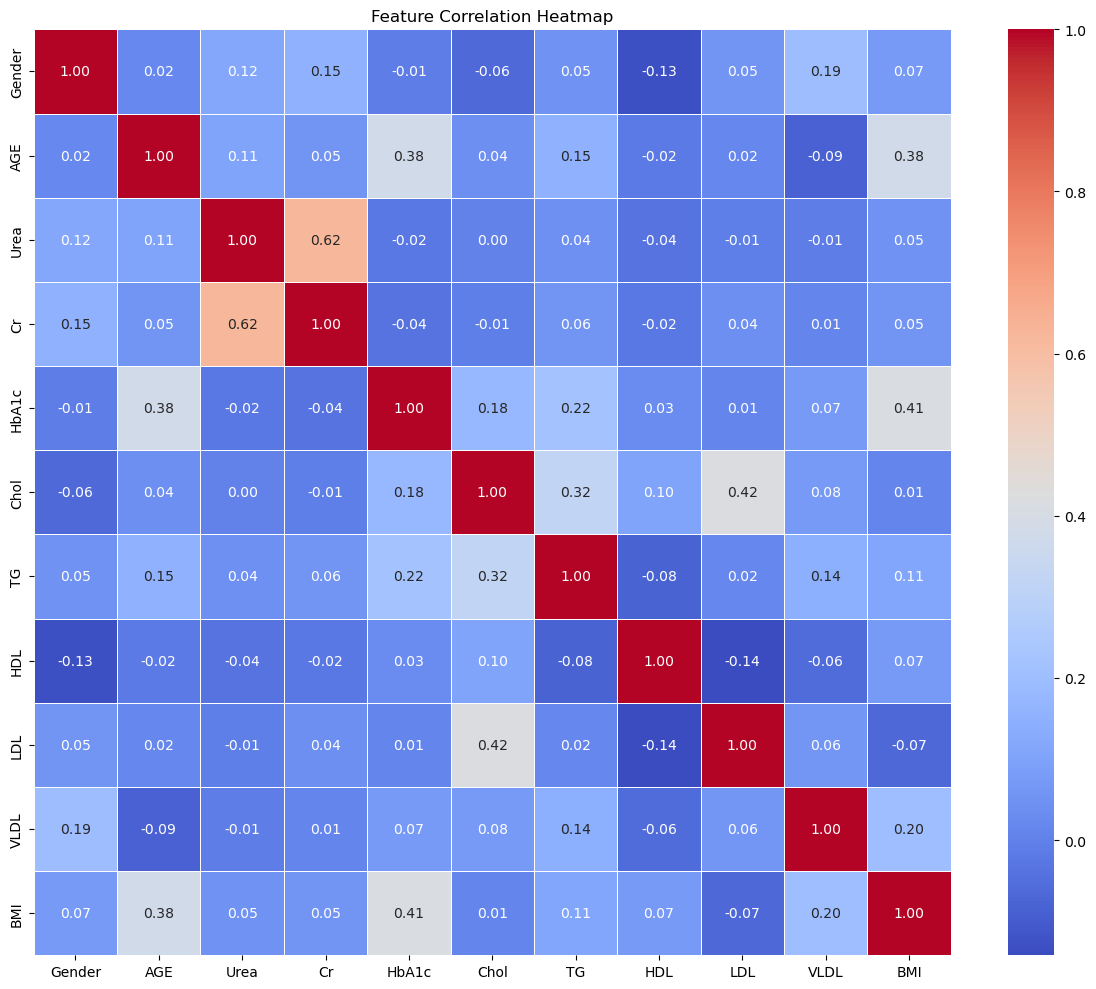

In [70]:
# Encode Gender temporarily for correlation
df_corr = df.copy()
df_corr['Gender'] = df_corr['Gender'].map({'M': 1, 'F': 0})

# Drop non-numeric columns
corr_features = df_corr[['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']]
corr_matrix = corr_features.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [84]:
# Prepare Features and Target for Modeling

le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

le_class = LabelEncoder()
y = le_class.fit_transform(df['CLASS'])  # N=0, P=1, Y=2

X = df[['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']]

print("Features shape:", X.shape)
print("Target classes:", le_class.classes_)

Features shape: (1000, 11)
Target classes: ['N' 'P' 'Y']


In [83]:
# Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set:", X_train_scaled.shape)
print("Test set:", X_test_scaled.shape)

Training set: (800, 11)
Test set: (200, 11)


In [82]:
# Train Models

# Logistic Regression (uses scaled data)
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Decision Tree (uses unscaled - better for trees)
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Random Forest (uses unscaled)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [81]:
# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le_class.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_dt, "Decision Tree")
evaluate_model(y_test, y_pred_rf, "Random Forest")


=== Logistic Regression ===
Accuracy: 0.945

Classification Report:
               precision    recall  f1-score   support

           N       0.86      0.90      0.88        21
           P       0.67      0.20      0.31        10
           Y       0.96      0.99      0.98       169

    accuracy                           0.94       200
   macro avg       0.83      0.70      0.72       200
weighted avg       0.94      0.94      0.93       200

Confusion Matrix:
 [[ 19   1   1]
 [  2   2   6]
 [  1   0 168]]

=== Decision Tree ===
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           N       1.00      0.95      0.98        21
           P       1.00      0.90      0.95        10
           Y       0.99      1.00      0.99       169

    accuracy                           0.99       200
   macro avg       1.00      0.95      0.97       200
weighted avg       0.99      0.99      0.99       200

Confusion Matrix:
 [[ 20   0   1]
 [  0 

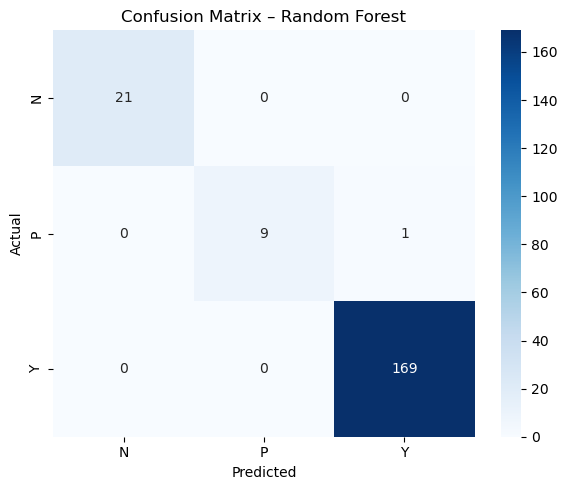

In [80]:
# Confusion Matrix Heatmap (Random Forest)
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues",
            xticklabels=le_class.classes_, yticklabels=le_class.classes_)
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [79]:
# Final Results Summary
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf)
    ]
})

results.sort_values(by="Accuracy", ascending=False)

,Model,Accuracy
2,Random Forest,0.995
1,Decision Tree,0.990
0,Logistic Regression,0.945
